In [570]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Full screen mode (feel free to zoom in and out)
from IPython.display import clear_output

import scipy.stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


/var/folders/2x/6rcq1qz10xn4qwq0yy9d4ytm0000gn/T/ipykernel_15050/4153701000.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Discretisation of BSDE 
***

### Forward Euler
***

The forward Euler scheme for the SDE
\begin{align*}
X_{0} &:= x_0\\
dX_{t} &:= b(t,X_{t})dt + \sigma(t, X^n_{t}) dB_t\\
\end{align*}
is given by
\begin{align*}
X^n_{t_0} &:= x_0\\
X^n_{t_{i+1}} &:= X^n_{t_i} + b(t_i,X^n_{t_i})h + \sigma(t_i, X^n_{t_{i}}) B_{t_i,t_{i+1}}
\end{align*}
 for $i = 0,\dots,n-1$.
 
### Backward Euler 
***
The backward Euler scheme for the BSDE
\begin{equation*}
\begin{cases}
X_t = x_0 + \int_0^t b(s,X_s)ds + \int_0^t \sigma(s,X_s)dB_s\\
Y_t = g(X_T) + \int_t^T f(s,X_s,Y_s,Z_s)ds - \int_t^T Z_s dB_s
\end{cases}
\end{equation*}


is given by $Y_{t_n}^n = g(X_{t_n}^n)$, and 
\begin{equation*}
Z_{t_i}^n := \frac{1}{h}\mathbb{E}_{t_i}\left[ Y_{t_{i+1}}^n B_{t_i,t_{i+1}}^\perp\right];\quad Y_{t_i}^n := \mathbb{E}_{t_i}\left[ Y_{t_{i+1}}^n + f(t_i,X_{t_i}^n, Y_{t_{i+1}}^n, Z_{t_i}^n )h \right].
\end{equation*}

## Example: Pricing and hedging for a vanilla call option
***
 Suppose we have a black scholes model such that the riskless asset has dynamics 
 
 \begin{equation*}
\begin{cases}
    d S_t^0 = rS_t^0 dt\\
    S_0^0 = 1
\end{cases}
\end{equation*}

and the risky asset has dynamics

 \begin{equation*}
\begin{cases}
    d S_t^1 = S_t^1( \mu dt + \sigma dW_t)\\
    S_0^1 = s_0^1.
\end{cases}
\end{equation*}

Let $V = (\lambda,\phi)$ be a replicating strategy for the call option $g(S_t^1) = (S_t^1 - K)^+$. Then 
\begin{cases}
    d V_t = \left[ r(V_t - \phi_t S_t^1) + \mu S_t^1 \phi_t \right] dt + \sigma S_t^1 \phi_t d B_t,\\
    V_T = g(S_T^1).
\end{cases}
Letting $Y_t := V_t$ and $Z_t := \sigma \phi_t S_t^1$ we get the BSDE

 \begin{equation*}
\begin{cases}
    d Y_t = \left[ rY_t + \frac{(\mu-r)}{\sigma}Z_t \right] dt + Z_t d B_t,\\
    Y_T = g(S_T^1).
\end{cases}
\end{equation*}

We begin by modelling the stock via a Forward Euler scheme.




In [571]:
# Parameters

M = 5000 # number of samples
T = 1 # time horizon
N = 300 # number of points
h = T/N # time step
x0 = 100 # initial position / stock price
K = 120 # strike
J = 20 # size of monomial basis
r = 0.05 # risk free rate
mu = 0.1 # drift
sigma = 0.4 # volatility

In [572]:

z = np.random.normal(0, 1, (M,N)) # independent normals
stock_samples = np.ones((M,N))*x0 # initialise the samples

for i in range(1,N): # the forward Euler scheme implemented
    stock_samples[:,i] = stock_samples[:,i-1] + mu * h * stock_samples[:,i-1]  +    sigma * np.sqrt(h) * np.multiply( stock_samples[:,i-1] , z[:,i-1]  )

# the European call evaluated at terminal time
terminal_condition = np.array([ max(0,stock_samples[i][-1] - K) for i in range(M)  ])


We plot 25 sample paths of the stock:

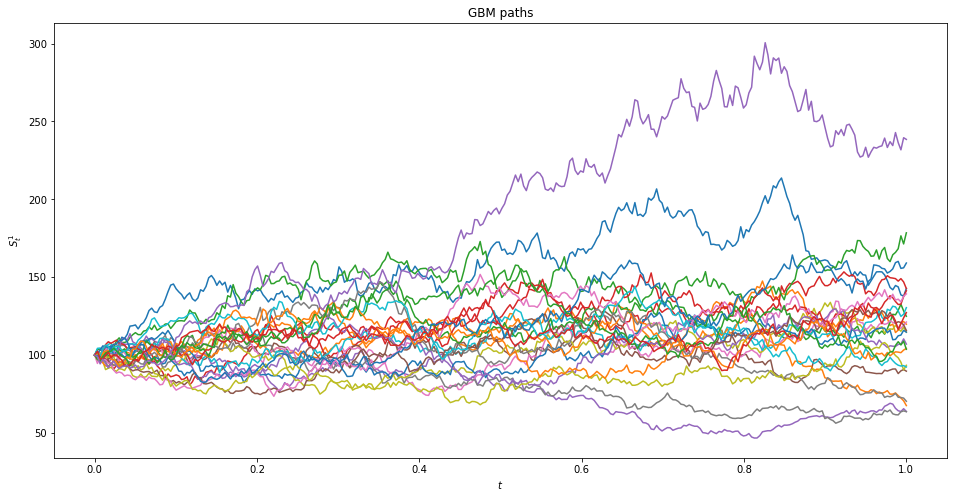

In [573]:
fig, ax = plt.subplots(figsize = (16,8))
for i in range(25):

    ax.plot(np.linspace(0,T,len(stock_samples[0])) , stock_samples[i])
    ax.set_title('GBM paths')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$S_t^1$')


We plot the terminal values $g(S_T^1)$:

In [574]:
# fig, ax = plt.subplots(figsize = (16,8))
# for i in range(M):

#     ax.plot(np.linspace(0,M,len(terminal_condition)) , terminal_condition)
#     ax.set_title('European call evaluation at time $T$')
#     ax.set_xlabel('Samples')
#     ax.set_ylabel('$(S_T^1 - {} )^+$'.format(K))

We can now implement the Backward Euler scheme.

In [575]:
Y = []
Z = []

for i in range(1,N-1):
    # data
    
    g = terminal_condition # i.e. Y_{t_{i+1}}
    data = stock_samples[:,N-(i+1)]

    X = [] # data matrix
    for i in range(J):
        X.append([x**i for x in data])
    X = np.transpose(np.array(X))

    
    target_Z = np.multiply( g , (1/np.sqrt(h)) * np.random.normal(0,1,M) ) # regression target for Z
    reg_Z = LinearRegression().fit(X, target_Z)
    Z_hat = reg_Z.predict(X) # Our approximation for Z
 
    target_Y = g + h*( r*g + (Z_hat/data)*(mu-r)/sigma )  # regression target for Z
    reg_Y = LinearRegression().fit(X, target_Y)
    Y_hat = reg_Y.predict(X) # Our approximation for Y

    Y.insert(0,Y_hat)
    Z.insert(0,Z_hat)

    terminal_condition = Y_hat

# add t_0 terms 
g = terminal_condition

Z_hat  = np.ones(M) * ( sum( np.multiply( g, (1/np.sqrt(h)) * np.random.normal(0,1,M) ) ) / M )
Y_hat = np.ones(M) * ( sum( g + h * ( r * (g - Z_hat/sigma) + Z_hat * mu/sigma) ) / M )

Y.insert(0,Y_hat)
Z.insert(0,Z_hat)

Y = np.array(Y)
Z = np.array(Z)


Here we plot 25 sample paths of the value process $Y$.

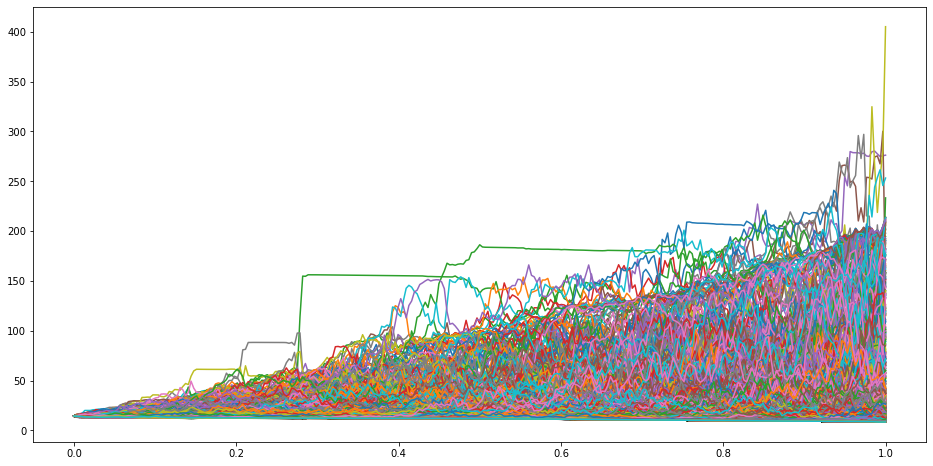

In [579]:
fig, ax = plt.subplots(1,figsize = (16,8)) # Plotting the path

xs = np.linspace(0,T,len(Y[:,0]))
for i in range(M):
    ax.plot(xs,Y[:,i])

In [577]:
price = Y[0,1]
price

14.46793185312646

We compare the above price with the BS-formula price.

In [578]:
def bsformula_undiscounted(cp, s, k, rf, t, v, div):
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """

        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp * s * np.exp(-div * t) * st.norm.cdf( cp * d1 )) - (cp * k * np.exp(-rf*t) * st.norm.cdf(cp*d2))
    
        return optprice

bsformula_undiscounted(1,x0,K,r,T,sigma,0)

10.805973916005627